In [1]:
import pandas_datareader as data
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import yfinance as yf
from tensorflow import keras
from IPython.display import Image
%matplotlib inline

**Make larger inputs (intra-day)**

In [2]:
intraday_data = yf.download(tickers="MSFT",
                            period="2y",
                            interval="1h",
                            auto_adjust=True)
intraday_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
2020-05-14 09:30:00-04:00,177.539993,178.889999,175.735703,175.789993,8841683
2020-05-14 10:30:00-04:00,175.800003,177.940002,175.679993,177.260101,6053059
2020-05-14 11:30:00-04:00,177.279999,178.169998,176.000000,176.830093,4640860
2020-05-14 12:30:00-04:00,176.860001,178.154999,176.449997,178.109894,3232095
2020-05-14 13:30:00-04:00,178.100006,178.320007,177.190002,178.219696,2931715


In [3]:
intraday_data.axes[0][0]

Timestamp('2020-05-14 09:30:00-0400', tz='America/New_York')

In [4]:
sequence_opens = intraday_data.values[: , 0]
sequence_opens.shape

(3526,)

In [5]:
pd.options.plotting.backend = "plotly"
intraday_data.plot(y=['Open'])

**Split and flip data randomly**

In [6]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [7]:
# choose a number of time steps
n_steps = 64
# split into samples
X, y = split_sequence(sequence_opens, n_steps)

In [8]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)
n_train = int(0.8*X.shape[0])
n_val = int(0.9*X.shape[0])

In [9]:
X_train, y_train = X[:n_train, :], y[:n_train]
X_val, y_val = X[n_train:n_val, :], y[n_train:n_val]
X_test, y_test = X[n_val:, :], y[n_val:]

In [10]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

**Wavenet**

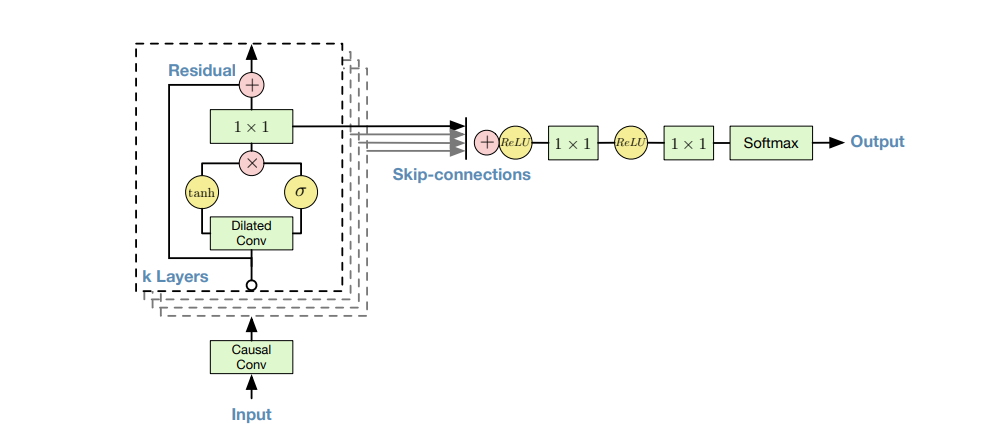

In [11]:
Image(filename='wnet.png') 

Wavenet uses TCNs "Temporal Convolutional Network" architecture

**Convolution for Time Series**

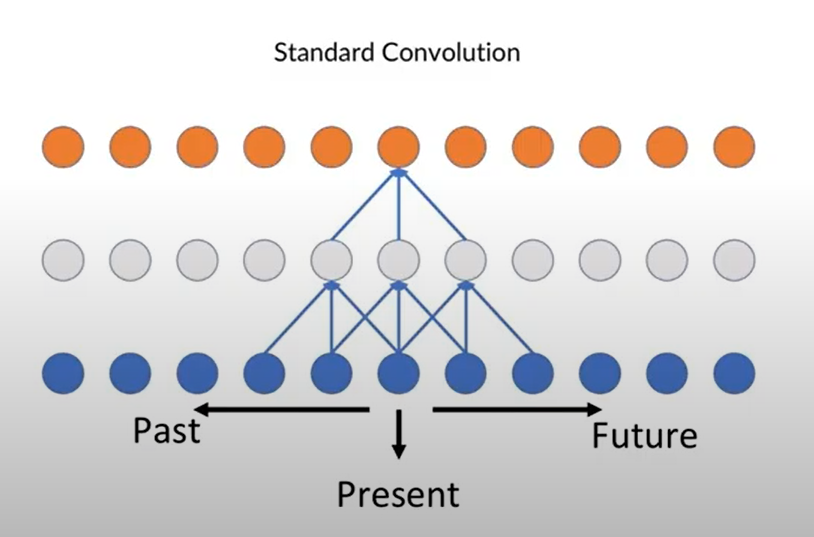

In [12]:
Image(filename='standard_conv.png') 

The standard convolution considers "future" values in the computation.

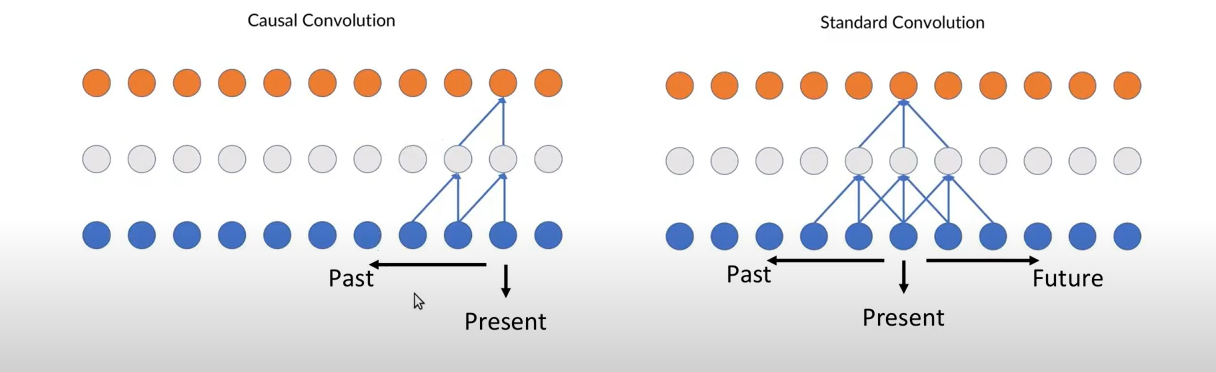

In [13]:
Image(filename='causal_conv.png') 

**Receptive Field**

The **receptive field** is the space that a convolutional kernel can see. For a convolutional kernel of size *K*, the output at position *t* can be dependent on input values up to *K - 1* steps in the past.

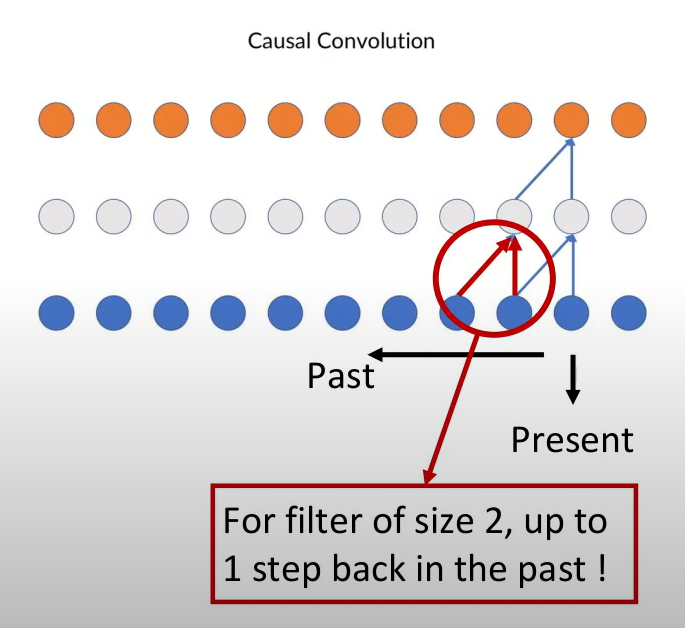

In [14]:
Image(filename='Rfield.png') 

How to deal with long range dependencies?

**Option 1: Large filters:** Big complexity, lot of parameters

**Option 2: Dilatation**

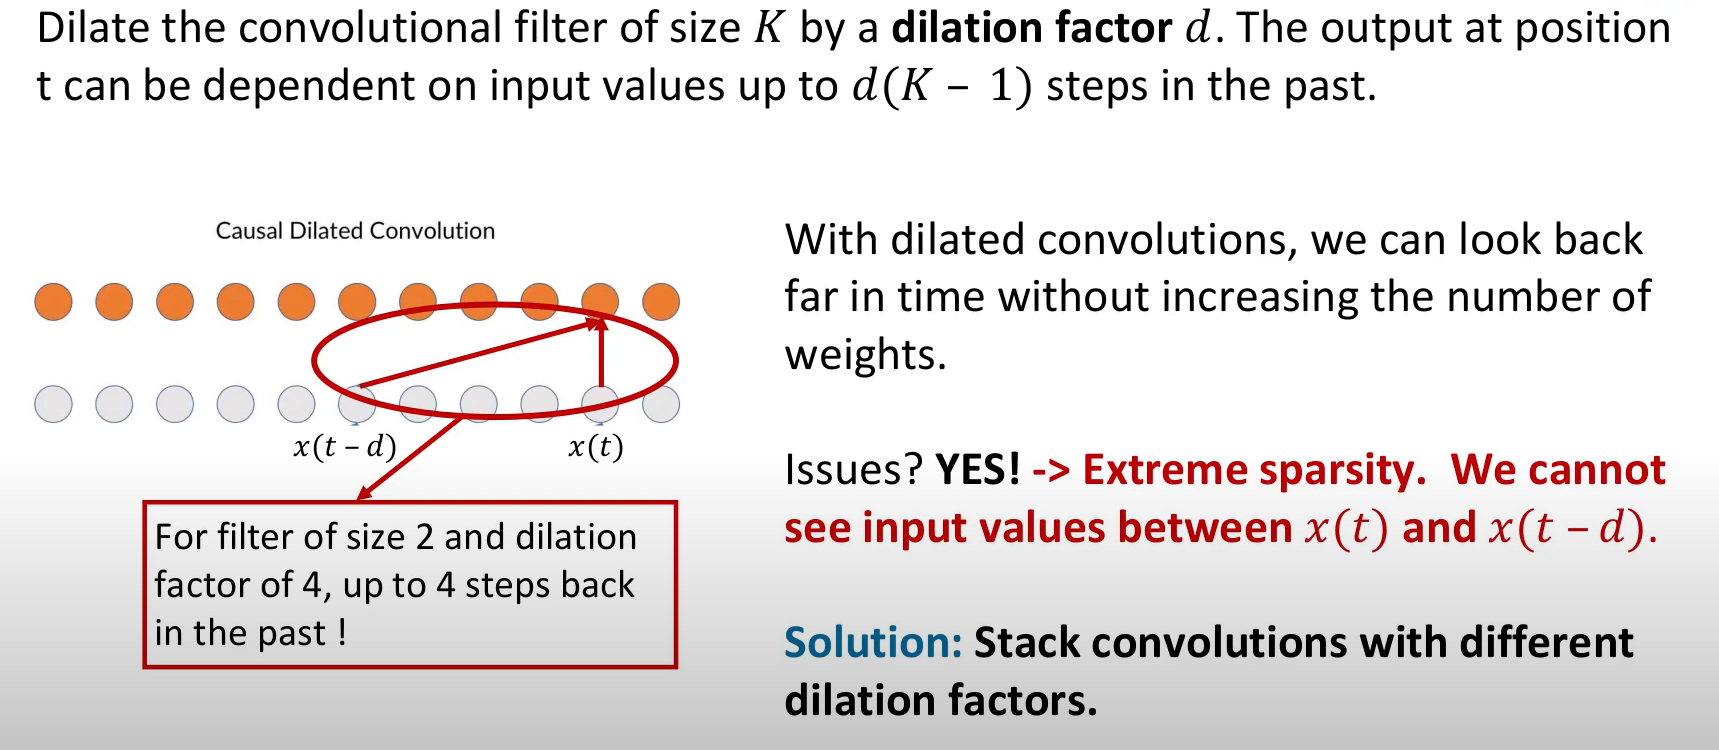

In [15]:
Image(filename='dil.png') 

Here comes the **Dilated Causal Convolutional Networks**, or, **Temporal Convolutional Networks (TCNs)**

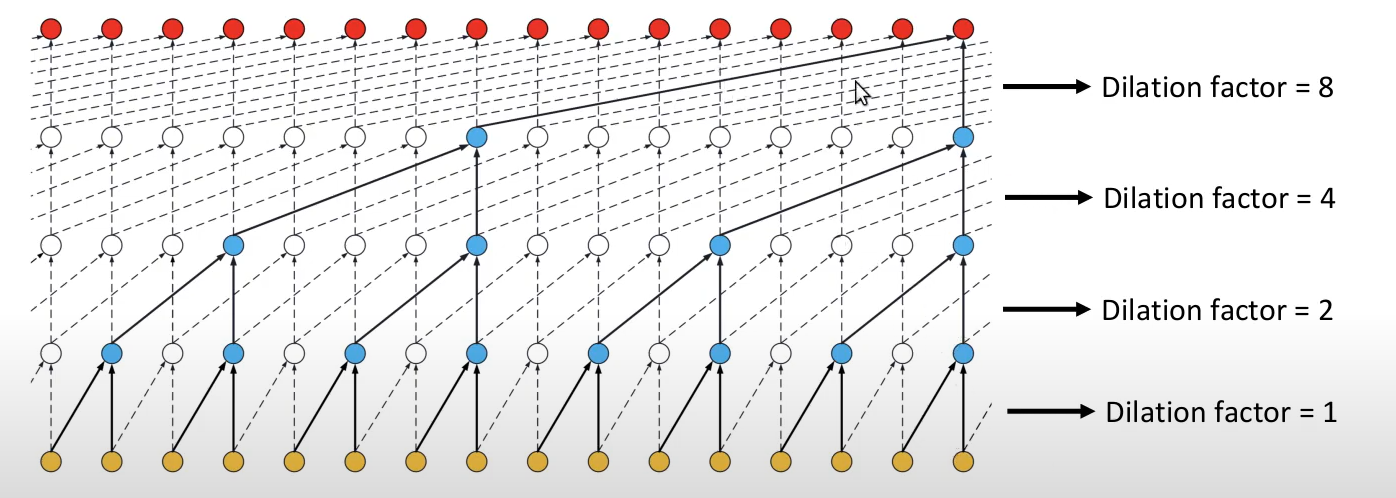

In [16]:
Image(filename='tcn.png') 

The receptive field *R* of a *TCN* with *l* layers and convolutional kernels of sike *k* is:
$$R = 2^l(k-1)$$

Skip-connections in each dilated causal convolution stack similar to those found in ResNet

**Residuals (Resnet paper)**

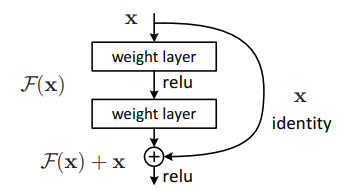

In [17]:
Image(filename='res.png') 

When deeper networks are able to start converging, a
degradation problem has been exposed: with the network
depth increasing, accuracy gets saturated (which might be
unsurprising) and then degrades rapidly. Unexpectedly,
such degradation is not caused by overfitting, and adding
more layers to a suitably deep model leads to higher training error, 

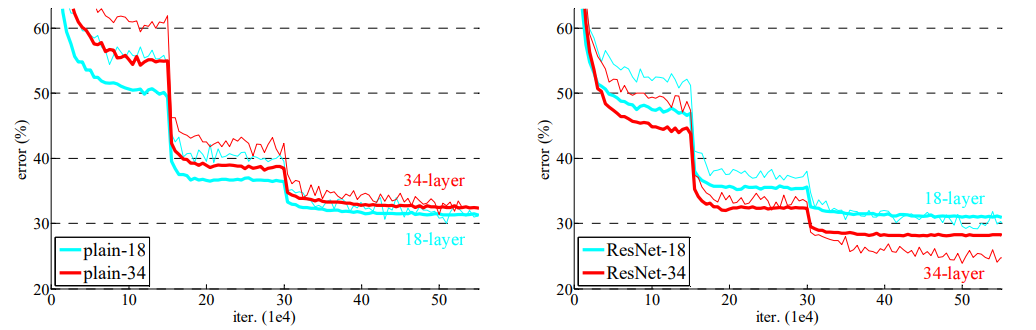

In [18]:
Image(filename='resnet.png') 

**Building my model**

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[n_steps, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=64, kernel_size=1))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mae')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 64, 32)            96        
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 64, 32)            2080      
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 64, 32)            2080      
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 64, 32)            2080      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 64, 32)            2080      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 64, 32)            2080      
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 64, 64)           

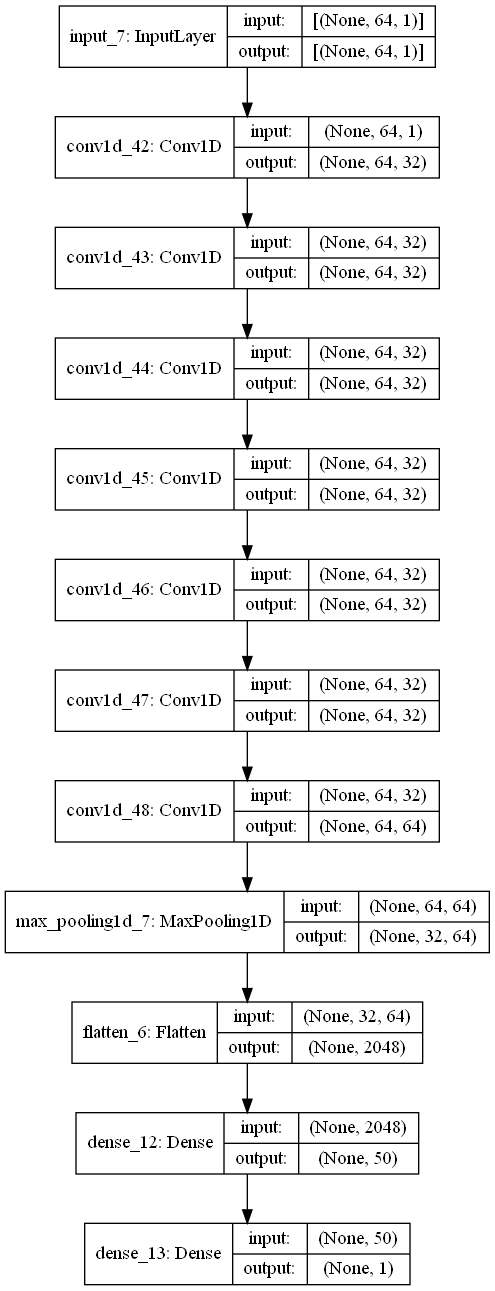

In [32]:
import tensorflow as tf
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

**Test and train evaluation**

In [33]:
history = model.fit(
    X_train,
    y_train,
    batch_size=8,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=0)

In [56]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


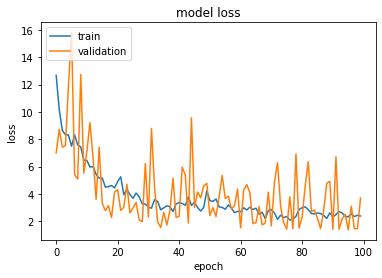

In [59]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

It seems that the model is overfitting

In [58]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
22/22 [==============================] - 0s 3ms/step - loss: 3.6157
test loss, test acc: 3.6157093048095703


In [48]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 1 sample")
predictions = model.predict(X_test[0, :, :].reshape(1, n_steps, n_features))
print("predictions shape:", predictions.shape)
print("First prediction:", predictions[0][0])
print("First actual value:", y_test[0])

Generate predictions for 1 sample
predictions shape: (1, 1)
First prediction: 337.6914
First actual value: 332.2200012207031


In [49]:
Y_hat_test = []
for x in X_test:
    x = x.reshape(1, n_steps, n_features)
    Y_hat_test.append(model.predict(x, verbose=0)[0][0])
Y_hat_test = np.array(Y_hat_test).reshape(X_test.shape[0])

**Scatter plots (correlation)**

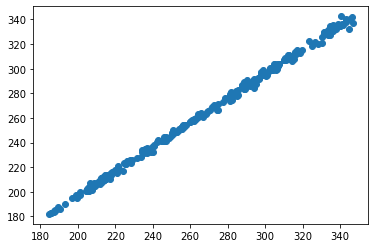

In [51]:
plt.scatter(Y_hat_test, y_test)

In [53]:
from scipy.stats.stats import pearsonr
r, p_value = pearsonr(Y_hat_test, y_test)
print("Pearson's correlation coefficient:", r)
print("p-value:", p_value)

Pearson's correlation coefficient: 0.999274645447652
p-value: 0.0


**Positional Encoding?**

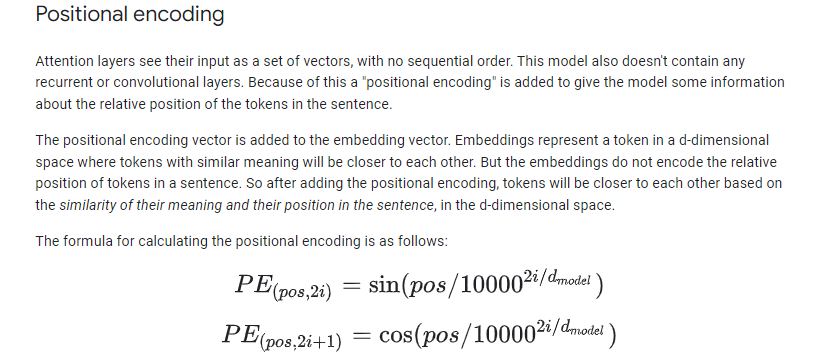

In [54]:
Image(filename='pe.png') 